In [120]:
# -*- coding: utf-8 -*-
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or
# implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import linregress

# 1.1 Základný opis dát spolu s ich charakteristikami, EDA
## A - Analýza štruktúr dát ako súbory

In [122]:
# load the datasets
df_profiles     = pd.read_csv("profiles.csv", sep='\t')
df_processes    = pd.read_csv("processes.csv", sep='\t')
df_devices      = pd.read_csv("devices.csv", sep='\t')
df_connections  = pd.read_csv("connections.csv", sep='\t')

# better info()
def analyze_dataframe(df):
    table = pd.DataFrame({
        'Missing Values': df.isnull().sum(),
        'Data Type': df.dtypes
    })

    rows, columns = df.shape
    duplicates = df.duplicated().sum()

    print(f"Shape: {rows} rows, {columns} columns")
    print(f"Duplicates: {duplicates}")

    display(table)

## PROFILES:

In [123]:
# displaying them
analyze_dataframe(df_profiles)
df_profiles.describe()

Shape: 2623 rows, 12 columns
Duplicates: 0


,Missing Values,Data Type
mail,0,object
imei,0,int64
birthdate,1180,object
username,0,object
user_id,0,int64
address,393,object
ssn,0,object
job,1836,object
registration,0,object
current_location,131,object


,imei,user_id
count,2.623000e+03,2623.000000
mean,3.944886e+18,1333.172703
std,3.314936e+18,755.604722
min,3.590434e+17,0.000000
25%,8.630331e+17,683.000000
50%,3.590434e+18,1358.000000
75%,8.630331e+18,1993.500000
max,8.630331e+18,2620.000000


In [124]:
df_profiles.head()

,mail,imei,birthdate,username,user_id,address,ssn,job,registration,current_location,company,name
0,melissajohnson@gmail.com,3590433799317661495,1927-05-24,onealjason,262,NaN,283-10-3548,NaN,"01/06/2021, 00:00:00","(Decimal('-66.534360'), Decimal('-20.750866'))",Hernandez-Gomez,Sara Allen
1,isabellahenderson@gmail.com,359043379931766338,1952-05-17,achang,351,"11074 Nelson Mills\nPort Douglaston, GA 41980",220-76-7219,NaN,11 Oct 2022,"(Decimal('64.457831'), Decimal('61.662934'))",Wood-Turner,Allen Day
2,abigail33@yahoo.com,359043379931766940,1929-07-04,burgessedward,2558,"0755 Scott Parks Apt. 877\nBowersborough, PW 0...",559-66-9181,Academic librarian,"05/17/2024, 00:00:00","(Decimal('-19.5608945'), Decimal('-175.139772'))","Underwood, Hughes and Alexander",Michelle Martin
3,haleyjanice@hotmail.com,3590433799317661990,1974-09-21,marshlisa,2619,NaN,198-29-6956,NaN,08 Jun 2019,"(Decimal('80.5917705'), Decimal('-34.292908'))",Ramos-Carroll,Samantha Lewis
4,brandy34@gmail.com,8630330696303482196,1926-02-20,gregorystephanie,1630,"99026 Dana Court Apt. 233\nEast Nathanhaven, W...",611-79-1165,NaN,2022/05/28,"(Decimal('-24.8391805'), Decimal('42.738041'))",Williams-Torres,Alan Smith


## ----------------------------------------------------------------------------------------

## PROCESSES:

In [125]:
analyze_dataframe(df_processes)
df_processes.describe()

Shape: 15056 rows, 23 columns
Duplicates: 179


,Missing Values,Data Type
ts,0,object
imei,0,int64
mwra,0,float64
p.android.externalstorage,0,float64
p.system,0,float64
p.android.packageinstaller,0,float64
p.android.settings,0,float64
p.android.chrome,0,float64
p.android.gm,0,float64
p.android.documentsui,0,float64


,imei,mwra,p.android.externalstorage,p.system,p.android.packageinstaller,p.android.settings,p.android.chrome,p.android.gm,p.android.documentsui,p.process.gapps,...,p.olauncher,p.dogalize,p.android.gms,p.simulator,p.katana,p.inputmethod.latin,p.browser.provider,p.android.defcontainer,p.android.vending,p.google
count,1.505600e+04,15056.000000,15056.000000,15056.000000,15056.000000,15056.000000,15056.000000,15056.000000,15056.000000,15056.000000,...,15056.000000,15056.000000,15056.000000,15056.000000,15056.000000,15056.000000,15056.000000,15056.000000,15056.000000,15056.000000
mean,3.862799e+18,0.626528,11.728076,11.149077,10.542660,9.902795,9.898074,9.976990,9.389388,0.180378,...,51.022992,49.472931,50.056319,49.716271,49.653745,50.233830,49.881578,49.842426,49.569623,49.760970
std,3.324063e+18,0.483742,2.378698,2.313953,2.551402,2.471244,2.572478,2.751660,2.366524,2.045401,...,13.775598,28.964083,28.837409,28.976797,28.923394,28.852168,29.027833,28.936261,29.057573,28.848557
min,3.590434e+17,0.000000,3.463510,3.050450,1.914620,2.010490,0.879270,0.000000,1.613180,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.630331e+17,0.000000,10.125405,9.424480,8.613357,8.080500,8.042817,8.053158,7.783875,0.001080,...,41.734795,24.467462,25.037925,24.731063,24.365138,25.168135,24.620715,24.551365,24.117705,24.665115
50%,3.590434e+18,1.000000,11.836125,11.326740,10.539715,9.822725,9.915515,9.872410,9.206940,0.006820,...,51.112325,49.266070,50.406650,49.289320,49.556385,50.022345,49.899465,49.543915,49.971220,49.455820
75%,8.630331e+18,1.000000,13.382025,12.882887,12.439132,11.795917,11.822162,11.894415,10.726888,0.043490,...,60.395437,74.715418,75.068038,74.884318,74.768535,75.281555,75.380165,74.968935,74.784970,74.802805
max,8.630331e+18,1.000000,20.060160,19.385580,20.321980,18.162090,17.996590,20.563610,20.220660,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


In [126]:
df_processes.head()

,ts,imei,mwra,p.android.externalstorage,p.system,p.android.packageinstaller,p.android.settings,p.android.chrome,p.android.gm,p.android.documentsui,...,p.olauncher,p.dogalize,p.android.gms,p.simulator,p.katana,p.inputmethod.latin,p.browser.provider,p.android.defcontainer,p.android.vending,p.google
0,2018-05-05 10:00:00,863033069630348727,0.0,12.71345,13.93596,7.37375,8.63678,7.59294,14.50294,12.49939,...,42.36961,24.39972,38.28394,39.75150,70.08727,35.39702,46.96978,94.36793,19.26230,8.71761
1,2018-05-05 10:01:00,359043379931766122,1.0,14.00354,13.66329,8.76390,8.45907,11.54816,9.23023,10.96660,...,43.50996,96.63160,35.35377,8.57826,21.30530,74.91400,28.78964,98.36045,2.67159,96.75896
2,2018-05-05 10:02:00,359043379931766312,0.0,9.12135,12.02995,15.24475,5.03619,9.25225,11.32397,8.95241,...,62.37735,72.10850,55.73124,85.87342,32.33386,55.19794,89.99140,80.51936,37.73145,89.03029
3,2018-05-05 10:03:00,8630330696303482329,0.0,10.02552,10.88392,15.14466,4.58649,7.65930,12.54341,6.13562,...,46.12254,40.36473,21.76176,0.98452,50.83786,90.78544,49.59389,51.32614,90.17701,39.10998
4,2018-05-05 10:04:00,3590433799317661099,1.0,10.18964,10.99286,8.52306,10.09407,13.85506,9.55446,7.87986,...,70.66280,51.37859,74.10500,42.63423,19.35378,47.21558,95.60708,96.18907,21.60796,33.91152


## ----------------------------------------------------------------------------------------

## DEVICES:

In [127]:
analyze_dataframe(df_devices)
df_devices.describe()

Shape: 2877 rows, 6 columns
Duplicates: 9


,Missing Values,Data Type
latitude,0,float64
longitude,0,float64
store_name,0,object
code,1,object
location,0,object
imei,0,int64


,latitude,longitude,imei
count,2877.000000,2877.000000,2.877000e+03
mean,29.006617,9.270159,3.845009e+18
std,23.226478,72.329065,3.303485e+18
min,-54.800000,-156.474320,3.590434e+17
25%,14.660000,-60.183100,8.630331e+17
50%,36.274620,9.152140,3.590434e+18
75%,46.135100,69.013540,8.630331e+18
max,68.798330,171.253640,8.630331e+18


In [128]:
df_devices.head()

,latitude,longitude,store_name,code,location,imei
0,30.35028,112.19028,Jingzhou,CN,Asia/Shanghai,359043379931766676
1,40.65995,-111.99633,Kearns,US,America/Denver,359043379931766486
2,16.05670,103.65309,Roi Et,TH,Asia/Bangkok,359043379931766536
3,-17.73648,168.31366,Port-Vila,VU,Pacific/Efate,359043379931766833
4,4.96667,10.70000,Tonga,CM,Africa/Douala,8630330696303481743


## ----------------------------------------------------------------------------------------

## CONNECTIONS:

In [129]:
analyze_dataframe(df_connections)
df_connections.describe()

Shape: 15056 rows, 13 columns
Duplicates: 179


,Missing Values,Data Type
ts,0,object
imei,0,int64
mwra,0,float64
c.android.chrome,0,float64
c.android.youtube,0,float64
c.dogalize,0,float64
c.android.gm,0,float64
c.katana,0,float64
c.UCMobile.intl,0,float64
c.UCMobile.x86,0,float64


,imei,mwra,c.android.chrome,c.android.youtube,c.dogalize,c.android.gm,c.katana,c.UCMobile.intl,c.UCMobile.x86,c.raider,c.updateassist,c.android.vending
count,1.505600e+04,15056.000000,15056.000000,15056.000000,15056.000000,15056.000000,15056.000000,15056.000000,15056.000000,15056.000000,15056.000000,15056.000000
mean,3.862799e+18,0.626528,11.031191,12.338105,11.166158,10.551474,10.006983,44.253556,48.334735,50.020566,50.291662,49.676756
std,3.324063e+18,0.483742,2.711483,1.988046,2.659134,2.710767,2.573995,11.698569,12.946345,28.939532,28.813347,28.691321
min,3.590434e+17,0.000000,1.264880,4.809800,1.448360,1.730240,1.384790,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.630331e+17,0.000000,9.135158,10.984255,9.299925,8.554515,8.136662,36.325515,39.660190,24.916545,25.573540,25.261332
50%,3.590434e+18,1.000000,11.096905,12.339915,11.265660,10.434125,9.846450,44.348005,48.354590,50.318470,50.540960,49.703525
75%,8.630331e+18,1.000000,12.966405,13.678990,13.054635,12.503325,11.820708,52.239500,57.055532,74.930567,75.256805,74.030860
max,8.630331e+18,1.000000,20.710650,21.205430,21.522060,21.665490,20.036020,100.000000,100.000000,100.000000,100.000000,100.000000


In [130]:
df_connections.head()

,ts,imei,mwra,c.android.chrome,c.android.youtube,c.dogalize,c.android.gm,c.katana,c.UCMobile.intl,c.UCMobile.x86,c.raider,c.updateassist,c.android.vending
0,2018-05-05 10:00:00,863033069630348727,0.0,9.60395,12.85710,14.28416,8.18164,12.05903,51.17664,65.36801,90.61716,26.55309,94.42555
1,2018-05-05 10:01:00,359043379931766122,1.0,10.90381,13.52655,15.47703,12.35803,9.31984,52.40056,57.22735,52.52705,57.31544,75.44486
2,2018-05-05 10:02:00,359043379931766312,0.0,7.96027,13.93330,11.48817,10.58834,16.41358,24.55276,80.27819,91.63614,49.51560,93.00705
3,2018-05-05 10:03:00,8630330696303482329,0.0,7.96574,14.28029,11.68449,13.39682,14.09485,44.81360,34.26693,56.53248,4.51390,27.06048
4,2018-05-05 10:04:00,3590433799317661099,1.0,12.77276,10.43295,10.16739,12.20800,6.18137,34.43871,59.20602,79.33347,27.09736,81.58699


## ----------------------------------------------------------------------------------------

### Zhrnutie analýzy dát
- #### Identifikovali sme duplicitne údajoe a chýbajúce hodnoty. Plánujeme ich odstrániť v nasledujúcej fáze
- #### Budeme sa sústrediť na systémové a používateľské aplikácie, pretože obsahujú relevantné údaje pre detekciu malware
- #### Zlučíme procesy, pripojenia a aplikácie do jedného datasetu na jednoduchšiu analýzu (je to HARD af, ani som to neskusal zatial xd, ale mozno to pomoze pre akoby lepsie usporiadanie a lepsie vysledky)
- #### Rozdelenie dát: Rozdelíme dáta na systémové a používateľské aplikácie (mozno v buducnosti idk fr)
- #### To cisielko moze reprezentovat CPU usage alebo cas, pocas kt. bola ap. pouzivana (fr neviem xd)

## ----------------------------------------------------------------------------------------
## ----------------------------------------------------------------------------------------

## B - Analýza jednotlivých atribútov, významné atribúty, ich distribúcie a základné deskriptívne štatistiky

#### predovšetkým sa budeme zaujimat o analýzu df_processes a df_connections, ktore suviasia so spravanim mwra asi najviac, vyjadrime si zavislosti cez korelacnu maticu

### DF_PROCESSES

In [131]:
df_numerical_processes = df_processes.select_dtypes(include=['float64', 'int64'])

correlation_matrix_processes = df_numerical_processes.corr()
correlation_matrix_processes

,imei,mwra,p.android.externalstorage,p.system,p.android.packageinstaller,p.android.settings,p.android.chrome,p.android.gm,p.android.documentsui,p.process.gapps,...,p.olauncher,p.dogalize,p.android.gms,p.simulator,p.katana,p.inputmethod.latin,p.browser.provider,p.android.defcontainer,p.android.vending,p.google
imei,1.000000,-0.002147,0.008186,-0.004662,0.005254,0.007931,-0.001573,-0.006580,-0.007149,0.013016,...,-0.006826,-0.007294,-0.003505,-0.005302,0.012131,-0.008941,-0.001808,-0.009520,0.005156,-0.004969
mwra,-0.002147,1.000000,0.295697,-0.300880,0.008005,0.292846,0.277986,-0.525956,-0.309486,0.053703,...,-0.004734,0.017844,0.008461,0.004626,-0.008713,-0.009371,0.009521,-0.004379,-0.000621,0.000392
p.android.externalstorage,0.008186,0.295697,1.000000,-0.194900,-0.244043,-0.065532,0.223123,-0.222338,0.049249,-0.010362,...,-0.006799,0.016367,0.016606,0.006203,0.005495,0.008588,0.000695,-0.011488,0.001269,-0.000499
p.system,-0.004662,-0.300880,-0.194900,1.000000,-0.385667,-0.413815,0.094967,0.323706,0.164477,0.003598,...,0.010016,-0.008518,0.011784,-0.023585,0.004770,0.002019,-0.014905,0.001481,-0.004686,-0.004595
p.android.packageinstaller,0.005254,0.008005,-0.244043,-0.385667,1.000000,0.337833,-0.338372,0.095900,-0.199744,-0.016069,...,-0.000083,-0.006811,-0.006361,-0.002043,0.010758,0.002441,0.002603,-0.011914,-0.010243,0.008627
p.android.settings,0.007931,0.292846,-0.065532,-0.413815,0.337833,1.000000,-0.309663,-0.275853,-0.140852,0.074836,...,-0.006115,0.000078,0.000175,0.010110,-0.000600,-0.000642,0.009488,0.001338,-0.011936,-0.003254
p.android.chrome,-0.001573,0.277986,0.223123,0.094967,-0.338372,-0.309663,1.000000,-0.162327,-0.173353,0.105886,...,-0.000573,0.018323,0.011535,-0.000855,-0.006019,0.005455,0.002126,0.011755,0.002549,-0.001312
p.android.gm,-0.006580,-0.525956,-0.222338,0.323706,0.095900,-0.275853,-0.162327,1.000000,0.271789,-0.036130,...,-0.000859,-0.006605,0.005954,-0.008839,0.019904,0.009395,-0.007223,-0.009688,-0.003363,-0.005139
p.android.documentsui,-0.007149,-0.309486,0.049249,0.164477,-0.199744,-0.140852,-0.173353,0.271789,1.000000,-0.105842,...,0.011653,-0.004331,-0.010779,0.010446,0.009018,0.003941,-0.007300,-0.010155,0.004417,-0.000409
p.process.gapps,0.013016,0.053703,-0.010362,0.003598,-0.016069,0.074836,0.105886,-0.036130,-0.105842,1.000000,...,-0.012516,0.017562,0.006597,0.000594,0.002028,0.012425,-0.000137,-0.004153,-0.015410,-0.000231


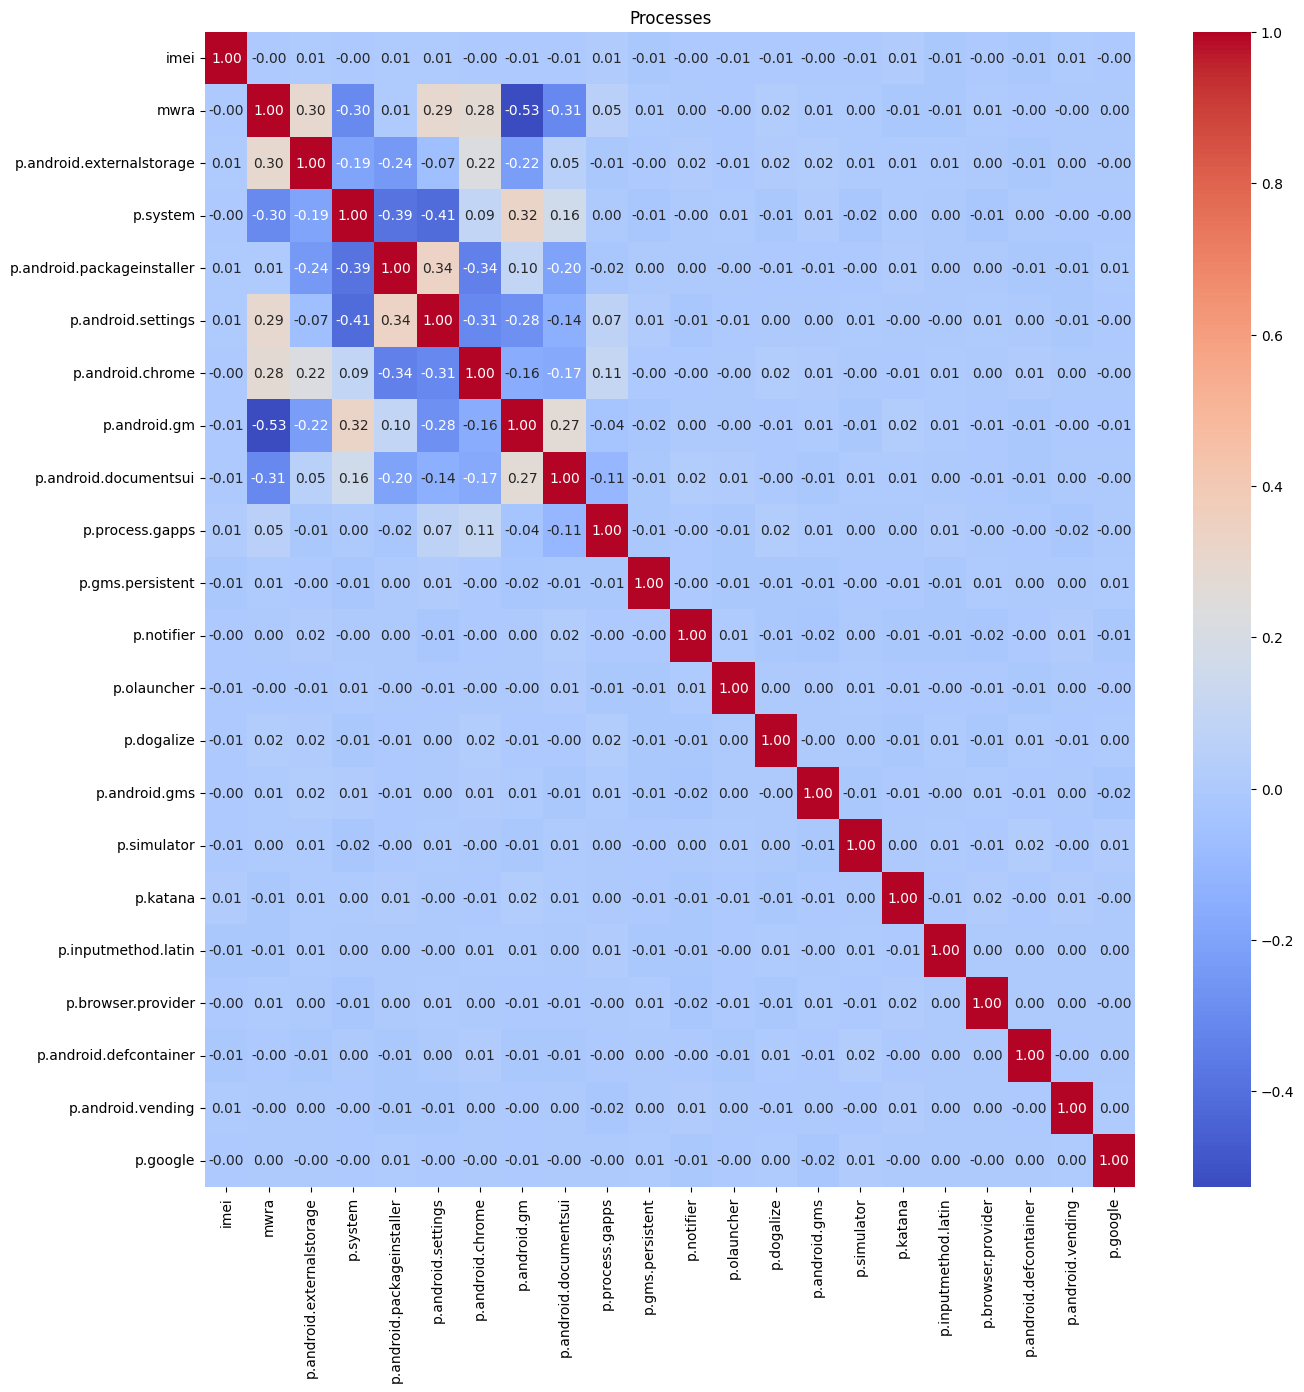

In [132]:
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix_processes, annot=True, cmap="coolwarm", fmt='.2f')
plt.title("Processes")
plt.show()

#### z tychto vyberieme (na zaklade korelacie s mwra):
- #### p.android.gm
- #### p.android.documentsui
- #### p.system

- #### p.android.externalstorage
- #### p.android.settings
- #### p.android.chrome

# note: (pozriet si aj tie co koreluju medzi sebou (nie len s mwra), lebo su SUS xd)
# + idk ale mozno aj vymazat tie stlpce, kt. vobec nekoreluju bo nam su na koko*(s)

In [133]:
significant_processes = [
    "p.android.gm", 
    "p.android.documentsui",
    "p.system",
    "p.android.externalstorage",
    "p.android.settings",
    "p.android.chrome"]

descriptive_stats = df_processes[significant_processes].describe()
descriptive_stats

,p.android.gm,p.android.documentsui,p.system,p.android.externalstorage,p.android.settings,p.android.chrome
count,15056.000000,15056.000000,15056.000000,15056.000000,15056.000000,15056.000000
mean,9.976990,9.389388,11.149077,11.728076,9.902795,9.898074
std,2.751660,2.366524,2.313953,2.378698,2.471244,2.572478
min,0.000000,1.613180,3.050450,3.463510,2.010490,0.879270
25%,8.053158,7.783875,9.424480,10.125405,8.080500,8.042817
50%,9.872410,9.206940,11.326740,11.836125,9.822725,9.915515
75%,11.894415,10.726888,12.882887,13.382025,11.795917,11.822162
max,20.563610,20.220660,19.385580,20.060160,18.162090,17.996590


#### pomocou histogramov, zistime normalitu tychto atributov, vieme urcit aj odlahle hodnoty, ale na to pouzijeme boxploty

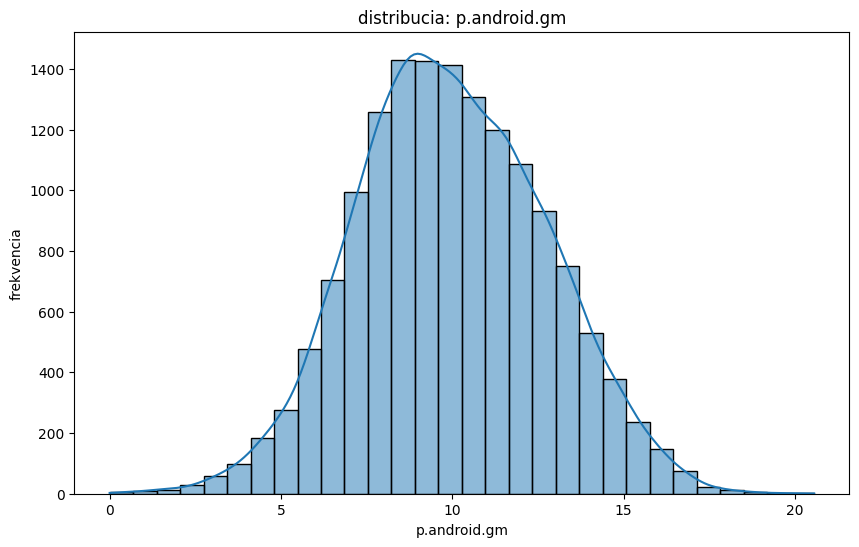

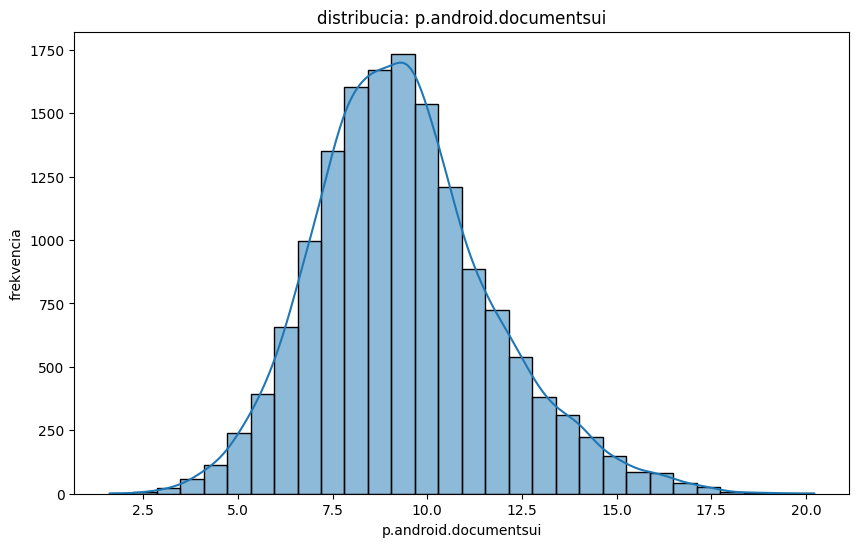

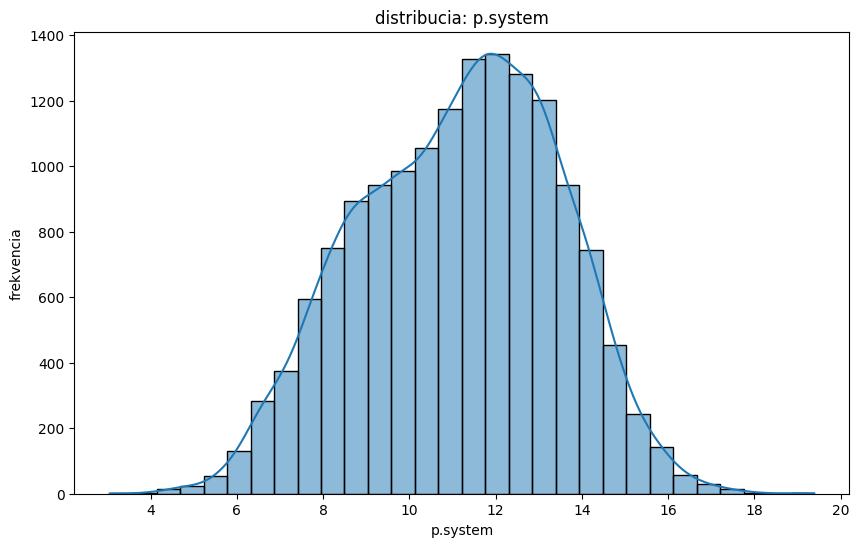

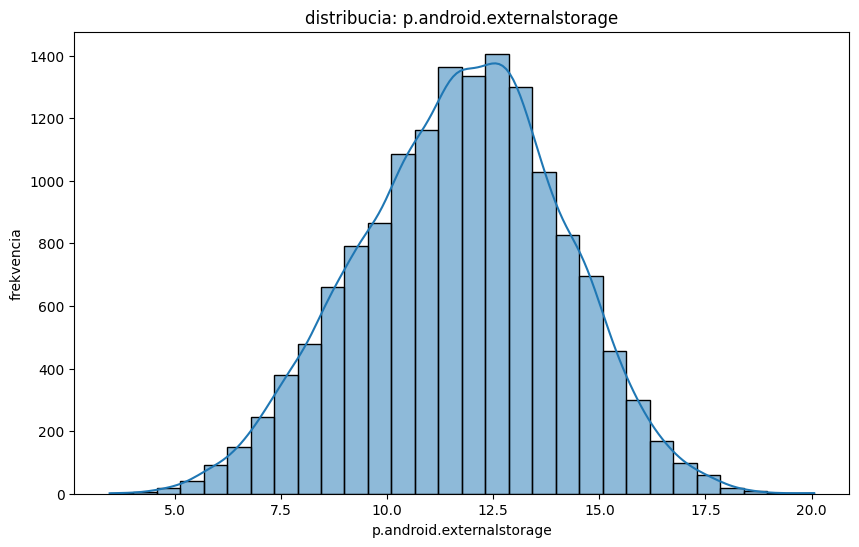

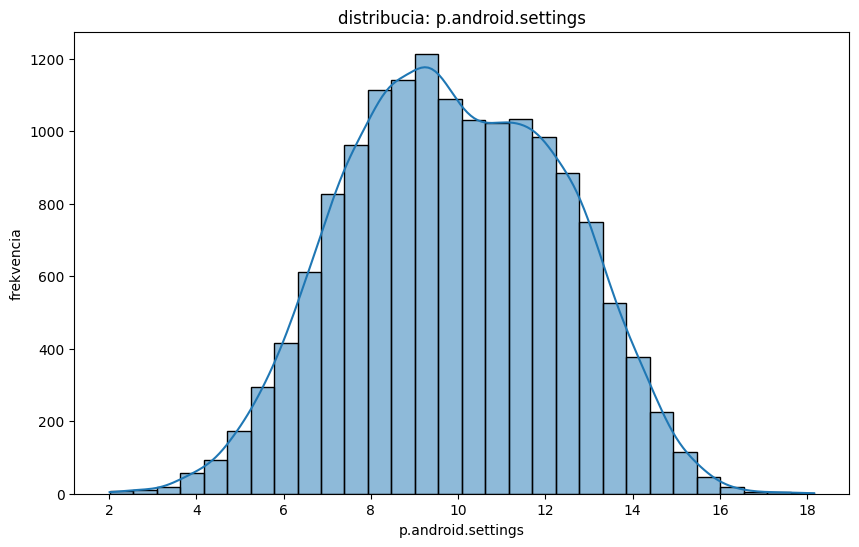

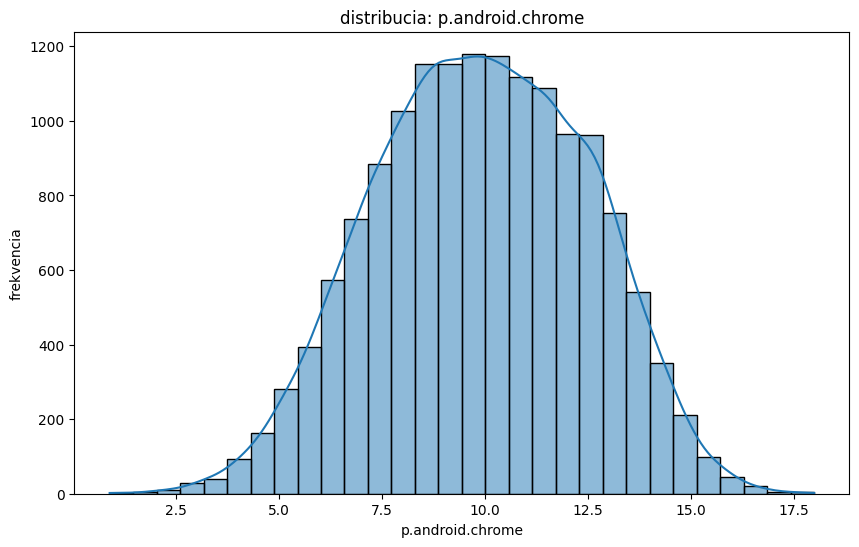

In [134]:
for attribute in significant_processes:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_processes[attribute], bins=30, kde=True)
    plt.title(f'distribucia: {attribute}')
    plt.xlabel(attribute)
    plt.ylabel('frekvencia')
    plt.show()

#### pouzijeme boxploty na identifikaciu odlahlich hodnot, ptm pojdu dorici

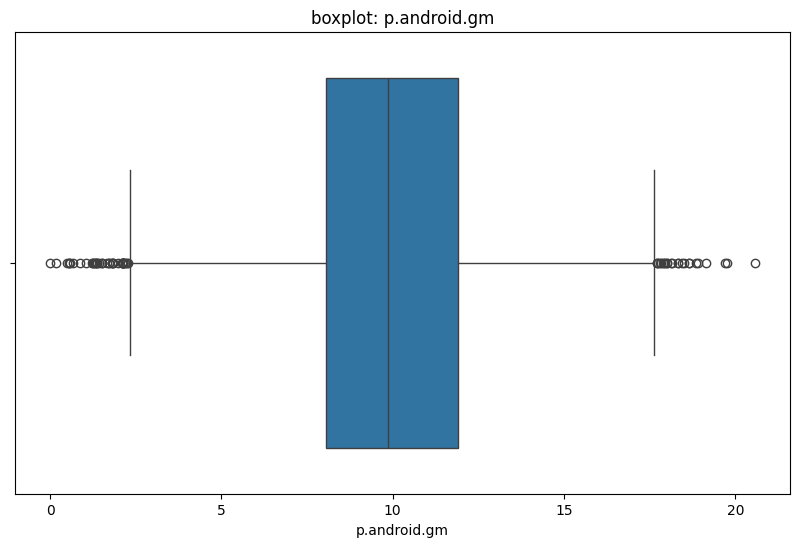

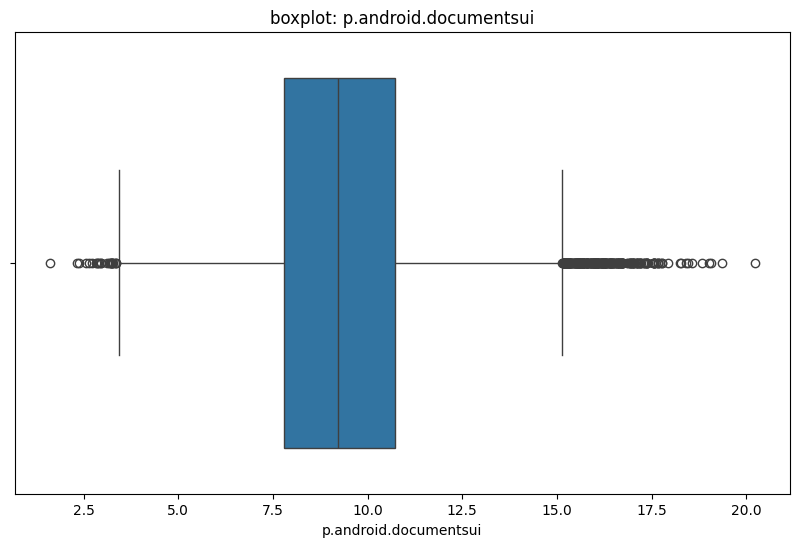

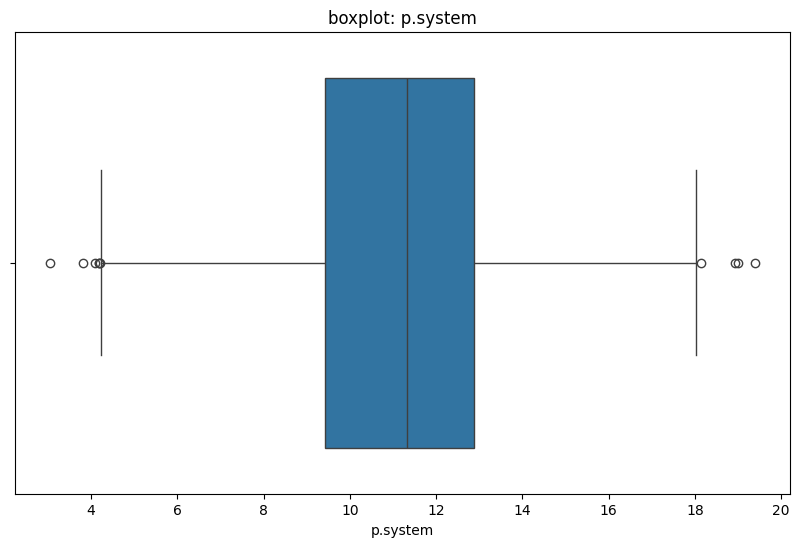

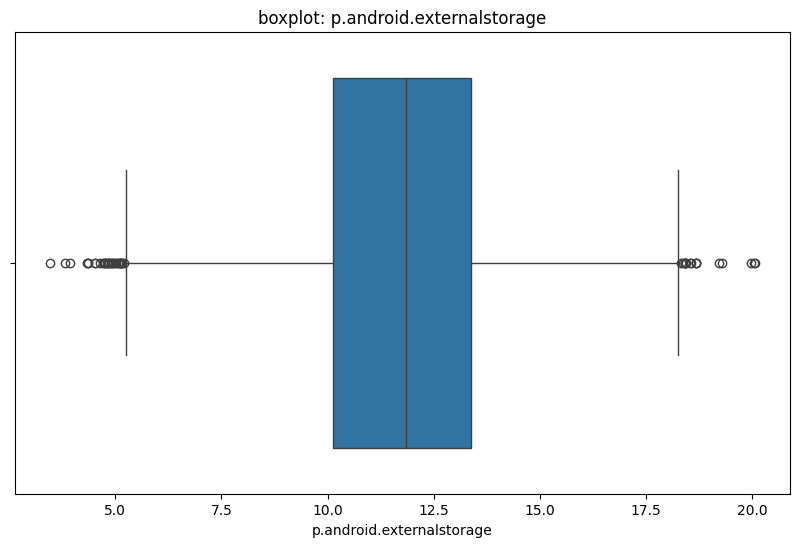

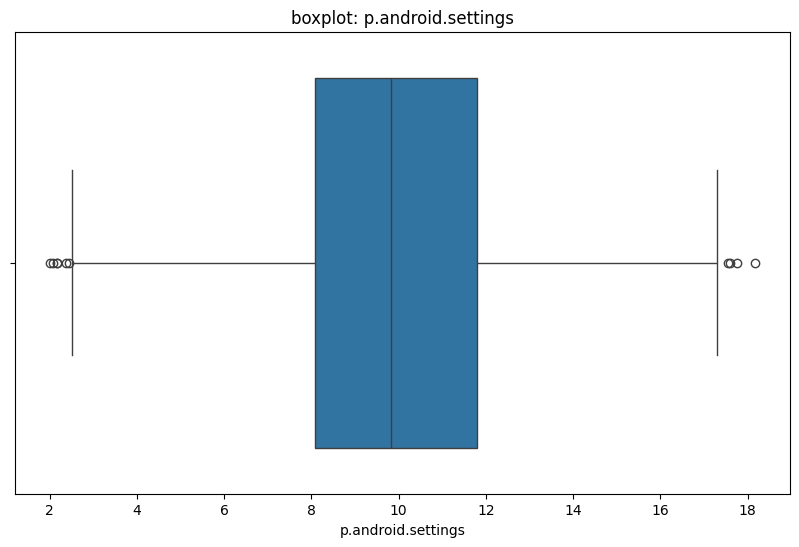

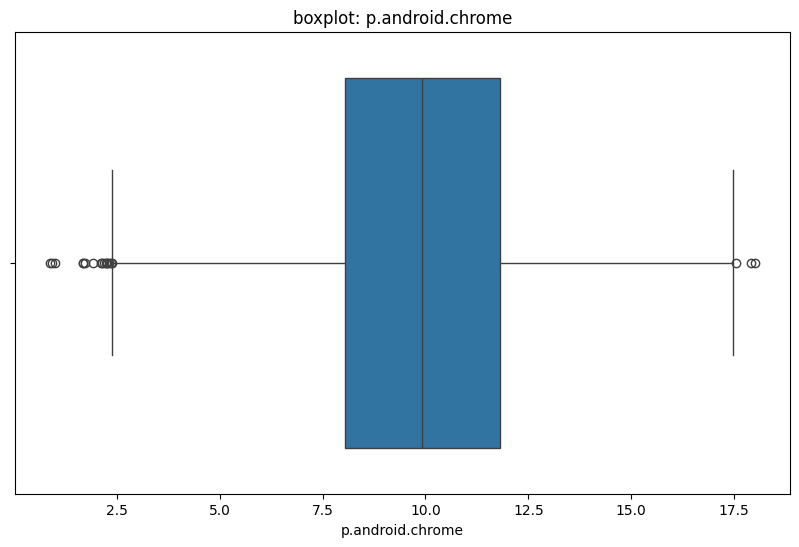

In [135]:
for attribute in significant_processes:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df_processes[attribute])
    plt.title(f'boxplot: {attribute}')
    plt.xlabel(attribute)
    plt.show()

## ----------------------------------------------------------------------------------------

### DF_CONNECTIONS

In [136]:
df_numerical_connections = df_connections.select_dtypes(include=['float64', 'int64'])

correlation_matrix_connections = df_numerical_connections.corr()
correlation_matrix_connections

,imei,mwra,c.android.chrome,c.android.youtube,c.dogalize,c.android.gm,c.katana,c.UCMobile.intl,c.UCMobile.x86,c.raider,c.updateassist,c.android.vending
imei,1.000000,-0.002147,0.004225,-0.016981,-0.001106,-0.012726,-0.001440,-0.013533,-0.002269,-0.021806,0.008477,-0.014369
mwra,-0.002147,1.000000,0.533619,-0.002635,-0.269175,-0.000152,-0.558710,-0.005531,-0.002420,-0.009644,-0.002077,-0.002485
c.android.chrome,0.004225,0.533619,1.000000,-0.206778,-0.352361,-0.196666,-0.566236,-0.004942,-0.003650,-0.014959,-0.007104,-0.003091
c.android.youtube,-0.016981,-0.002635,-0.206778,1.000000,0.111308,0.168103,0.300575,0.002794,0.002357,-0.011717,0.004649,0.003297
c.dogalize,-0.001106,-0.269175,-0.352361,0.111308,1.000000,0.345799,0.308364,-0.000483,0.009702,0.011025,0.007821,0.014388
c.android.gm,-0.012726,-0.000152,-0.196666,0.168103,0.345799,1.000000,0.092677,0.008750,-0.001367,-0.000477,0.002514,0.006310
c.katana,-0.001440,-0.558710,-0.566236,0.300575,0.308364,0.092677,1.000000,0.007455,-0.007033,0.004990,0.001061,0.002635
c.UCMobile.intl,-0.013533,-0.005531,-0.004942,0.002794,-0.000483,0.008750,0.007455,1.000000,-0.006018,-0.012910,0.001859,0.003061
c.UCMobile.x86,-0.002269,-0.002420,-0.003650,0.002357,0.009702,-0.001367,-0.007033,-0.006018,1.000000,0.000730,-0.005107,-0.000800
c.raider,-0.021806,-0.009644,-0.014959,-0.011717,0.011025,-0.000477,0.004990,-0.012910,0.000730,1.000000,-0.003313,-0.000899


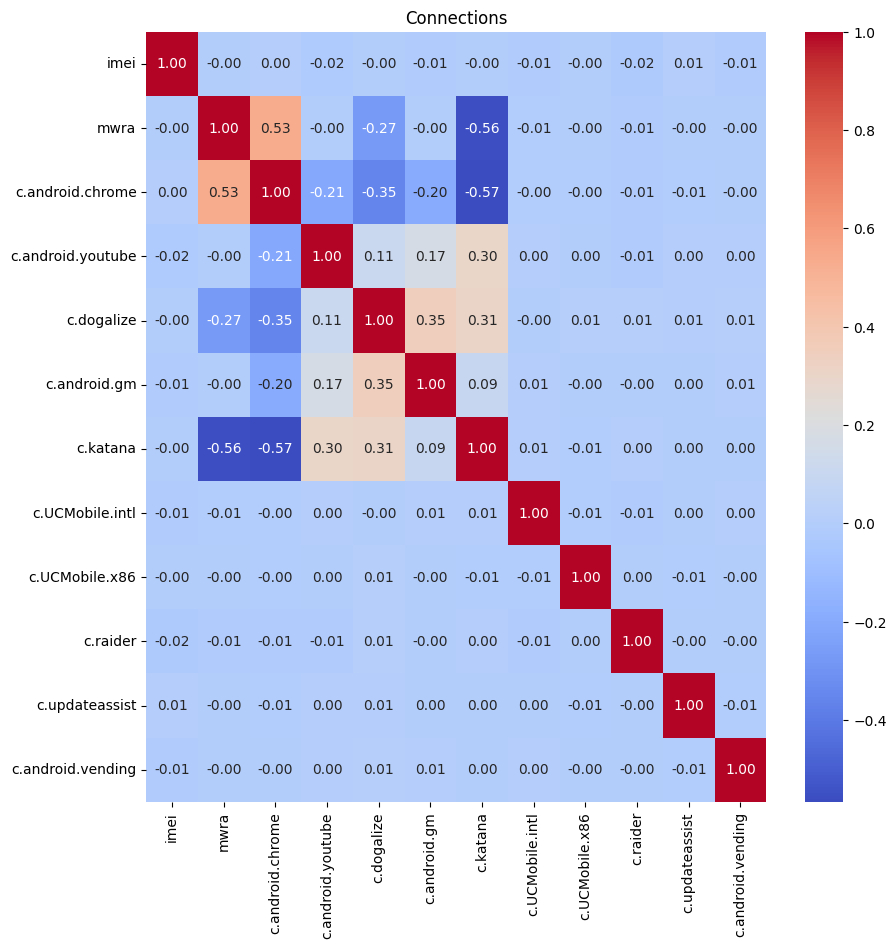

In [137]:
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix_connections, annot=True, cmap="coolwarm", fmt='.2f')
plt.title("Connections")
plt.show()

#### z tychto vyberieme (na zaklade korelacie s mwra):
- #### c.katana
- #### c.dogalize
- #### c.adroid.gm
- #### c.android.chrome

# note: (pozriet si aj tie co koreluju medzi sebou (nie len s mwra), lebo su SUS xd, napr katana s chromom atd ...)

In [138]:
significant_connections = [
    "c.katana",
    "c.dogalize",
    "c.android.chrome",
    "c.android.gm"
]

descriptive_stats = df_connections[significant_connections].describe()
descriptive_stats

,c.katana,c.dogalize,c.android.chrome,c.android.gm
count,15056.000000,15056.000000,15056.000000,15056.000000
mean,10.006983,11.166158,11.031191,10.551474
std,2.573995,2.659134,2.711483,2.710767
min,1.384790,1.448360,1.264880,1.730240
25%,8.136662,9.299925,9.135158,8.554515
50%,9.846450,11.265660,11.096905,10.434125
75%,11.820708,13.054635,12.966405,12.503325
max,20.036020,21.522060,20.710650,21.665490


#### pomocou histogramov, zistime normalitu tychto atributov, vieme urcit aj odlahle hodnoty, ale na to pouzijeme boxploty

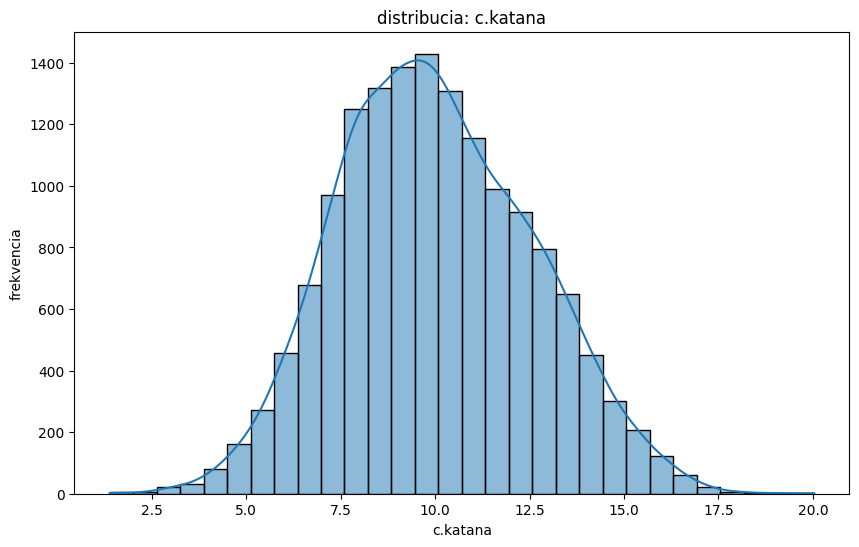

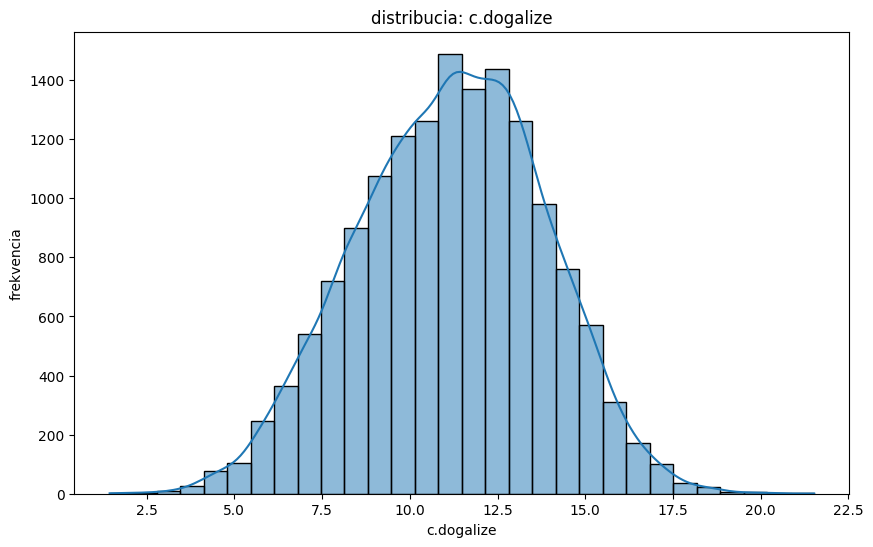

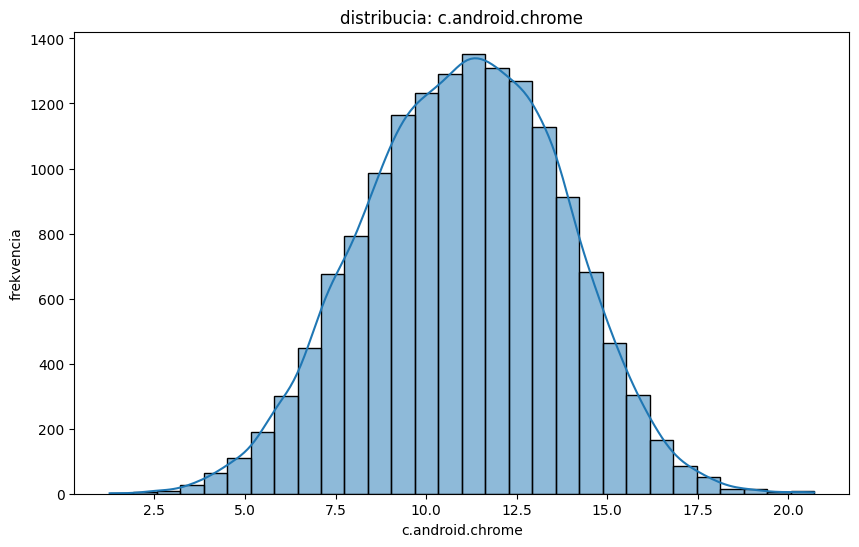

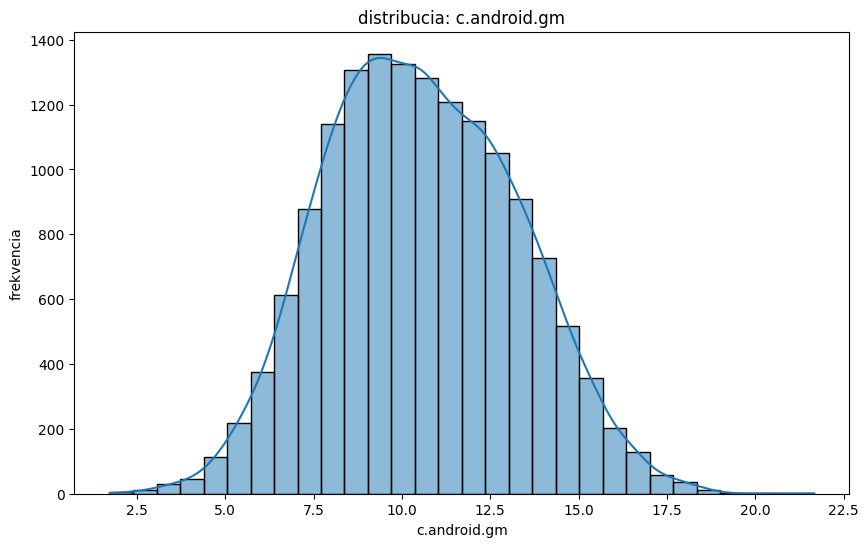

In [139]:
for attribute in significant_connections:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_connections[attribute], bins=30, kde=True)
    plt.title(f'distribucia: {attribute}')
    plt.xlabel(attribute)
    plt.ylabel('frekvencia')
    plt.show()

#### pomocou boxplotov analyzujeme odlahle hodnoty, ktore neskor mozeme poslat do faka (asi)

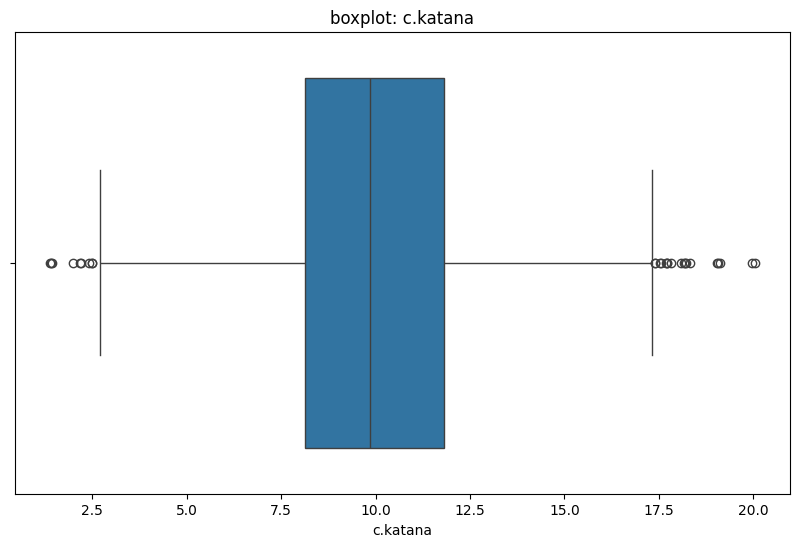

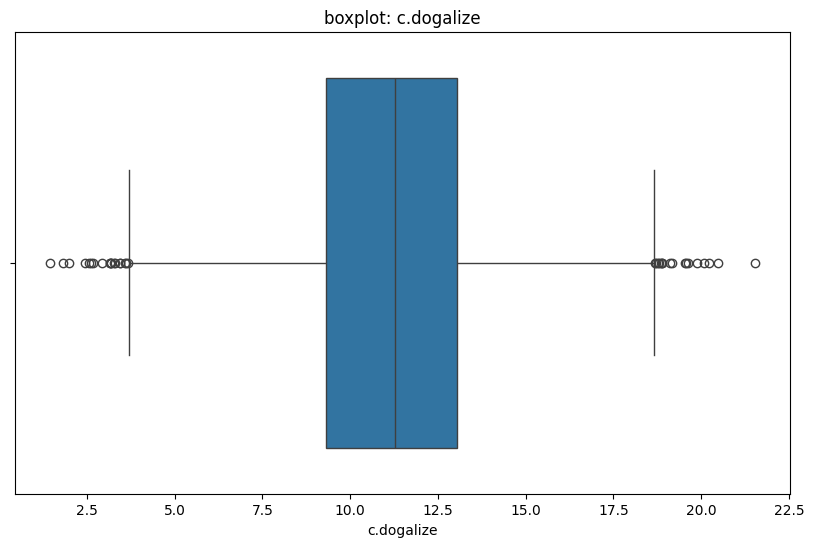

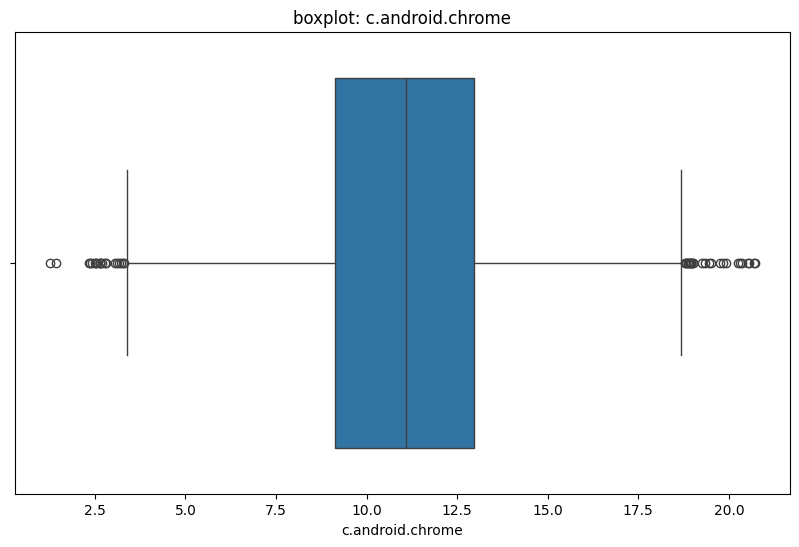

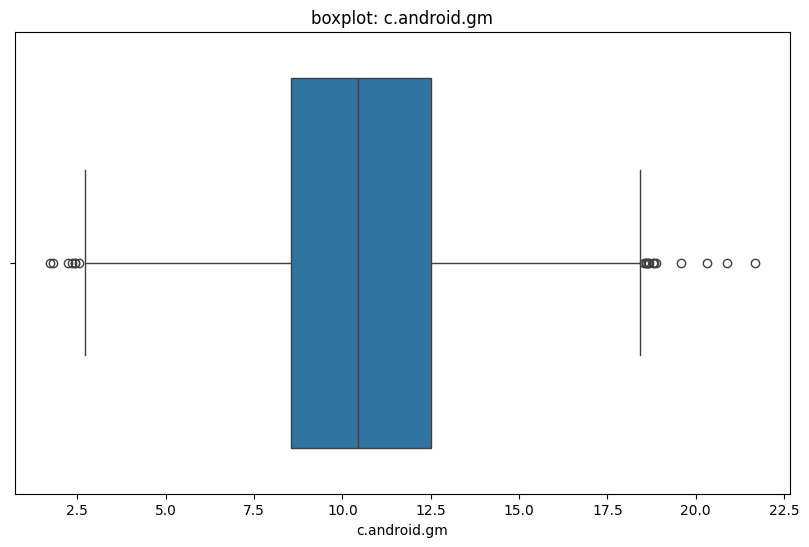

In [140]:
for attribute in significant_connections:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df_connections[attribute])
    plt.title(f'boxplot: {attribute}')
    plt.xlabel(attribute)
    plt.show()

# NOTE: uplne na random som si vsimol , ze vblastne , ked si pozries f.ex. connections: mas tam pre jedno imei viacero riadkov a pri nich aj casy, z toho vypliva, ze tie casy urcuju intervaly (random intervaly) a pravdepodobne aj nejaku postupnoost, ktora urcuje poradie tych procesov ako katana, ... google atd, resp. vyuzivanie CPU , idk kt. z tychto dvoch to treba mozno v buducnosti vydumat, idk ci ani tomu sam chapem co tupisem je 12 hodin skoro xd

## ----------------------------------------------------------------------------------------
## ----------------------------------------------------------------------------------------

## C - Párová analýza dát
#### idk , ci tomu chapem , ale napadlo ma , zeby sme spojili vsetky vyvolene atributy do jedneho dataframu a podla toho spravili korelacnu maticu (nechce sa mi ich spajat , pretoze fr neviem ako na to xd), idk vytvoril som aj novy .csv subor , len tak zo srandy xd

In [141]:
df_merged = pd.merge(df_connections, df_processes, on=['imei', 'ts'], how='inner')
df_merged = df_merged[significant_processes + significant_connections]
df_merged.to_csv('merged_data.csv', index=False)
df_merged.head()

,p.android.gm,p.android.documentsui,p.system,p.android.externalstorage,p.android.settings,p.android.chrome,c.katana,c.dogalize,c.android.chrome,c.android.gm
0,14.50294,12.49939,13.93596,12.71345,8.63678,7.59294,12.05903,14.28416,9.60395,8.18164
1,9.23023,10.96660,13.66329,14.00354,8.45907,11.54816,9.31984,15.47703,10.90381,12.35803
2,11.32397,8.95241,12.02995,9.12135,5.03619,9.25225,16.41358,11.48817,7.96027,10.58834
3,12.54341,6.13562,10.88392,10.02552,4.58649,7.65930,14.09485,11.68449,7.96574,13.39682
4,9.55446,7.87986,10.99286,10.18964,10.09407,13.85506,6.18137,10.16739,12.77276,12.20800


#### a vsetky atributy porovname v heatmape, repr. korelacie medzi vsetkymi atributmi

In [142]:
df_numerical_merged = df_merged.select_dtypes(include=['float64', 'int64'])

correlation_matrix_connections = df_numerical_merged.corr()
correlation_matrix_connections

,p.android.gm,p.android.documentsui,p.system,p.android.externalstorage,p.android.settings,p.android.chrome,c.katana,c.dogalize,c.android.chrome,c.android.gm
p.android.gm,1.000000,0.274992,0.324856,-0.222133,-0.278996,-0.160840,0.333291,0.073943,-0.383669,0.106537
p.android.documentsui,0.274992,1.000000,0.163918,0.052080,-0.145352,-0.172151,0.299984,0.121380,-0.434460,0.046751
p.system,0.324856,0.163918,1.000000,-0.194461,-0.415165,0.097683,0.188964,0.561786,-0.183035,0.354748
p.android.externalstorage,-0.222133,0.052080,-0.194461,1.000000,-0.065755,0.221215,-0.224283,-0.047795,0.113432,-0.196140
p.android.settings,-0.278996,-0.145352,-0.415165,-0.065755,1.000000,-0.310038,-0.330934,-0.531650,0.360285,-0.345341
p.android.chrome,-0.160840,-0.172151,0.097683,0.221215,-0.310038,1.000000,-0.328118,0.124433,0.448676,0.272630
c.katana,0.333291,0.299984,0.188964,-0.224283,-0.330934,-0.328118,1.000000,0.308258,-0.566922,0.095671
c.dogalize,0.073943,0.121380,0.561786,-0.047795,-0.531650,0.124433,0.308258,1.000000,-0.353417,0.347430
c.android.chrome,-0.383669,-0.434460,-0.183035,0.113432,0.360285,0.448676,-0.566922,-0.353417,1.000000,-0.197574
c.android.gm,0.106537,0.046751,0.354748,-0.196140,-0.345341,0.272630,0.095671,0.347430,-0.197574,1.000000


<Axes: >

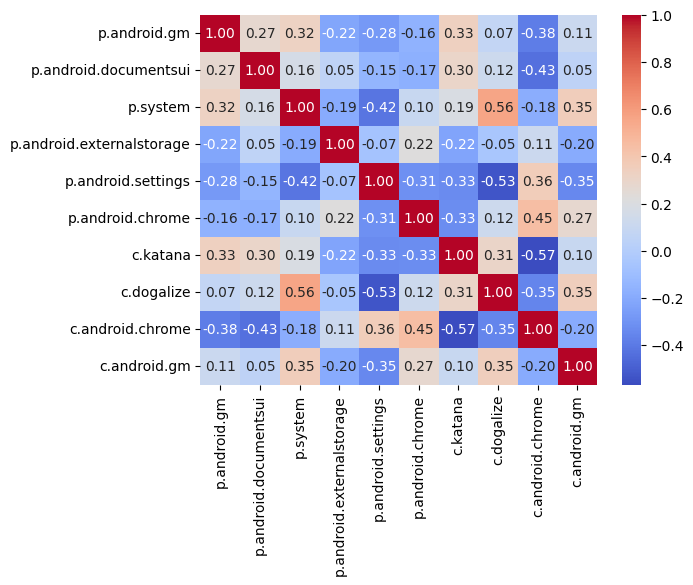

In [143]:
sns.heatmap(correlation_matrix_connections, annot=True, cmap="coolwarm", fmt='.2f')

#### porovnavame podobne atributy, za predpokladu, ze sa hodnoty budu rovnat

array([[<Axes: title={'center': 'c.android.vending'}>,
        <Axes: title={'center': 'p.android.vending'}>]], dtype=object)

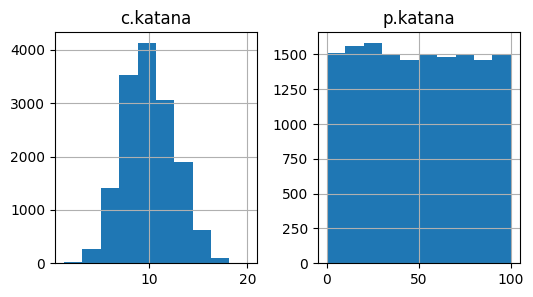

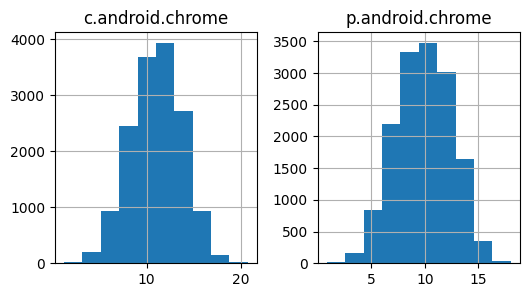

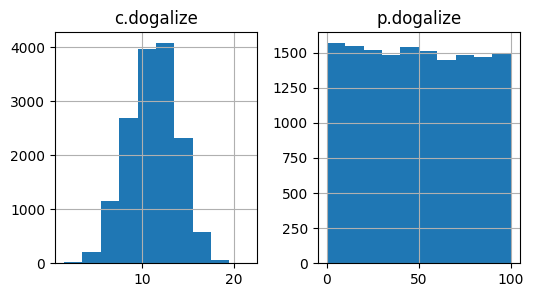

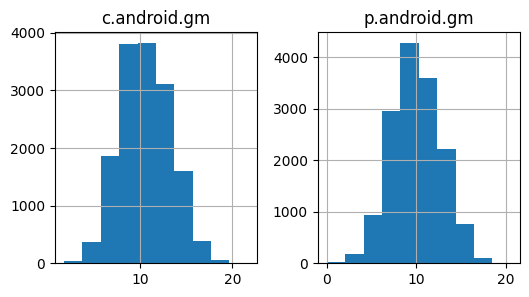

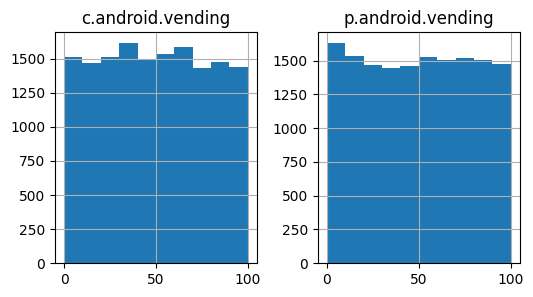

In [144]:
pd.DataFrame({'c.katana': df_connections['c.katana'], 'p.katana': df_processes['p.katana']}).hist(figsize=(6,3))
pd.DataFrame({'c.android.chrome': df_connections['c.android.chrome'], 'p.android.chrome': df_processes['p.android.chrome']}).hist(figsize=(6,3))
pd.DataFrame({'c.dogalize': df_connections['c.dogalize'], 'p.dogalize': df_processes['p.dogalize']}).hist(figsize=(6,3))
pd.DataFrame({'c.android.gm': df_connections['c.android.gm'], 'p.android.gm': df_processes['p.android.gm']}).hist(figsize=(6,3))
pd.DataFrame({'c.android.vending': df_connections['c.android.vending'], 'p.android.vending': df_processes['p.android.vending']}).hist(figsize=(6,3))

#### porovnatelne su chrome, gm a aj vending (cca xd)

## D - závislosti medzi predikovanou premennou a ostatnými premennými (sme identifikovali hore)
[heatmap](#df_processes) btw nejde ten link , ale snazil som sa xd

## E - naše prvotné zamyslenie k riešeniu zadania:
- myslime si, ze viacero atributov su medzi sebou prepojene a zavisle, ako napr. katana/chrome/ , atd
- zavisi od viacerych atributov, spojili sme ich do df_merged
- urcite bude treba kombinovat zaznamy z viacerych suborov, uz sme tak aj vykonali, no musime viac presetrit zavislosti medzi roznymi atributmy a tak ich nejako zoskupovat a nasledne riesit dalsie problemy

# 1.2 Identifikácia problémov, integrácia a čistenie dát
## A - prvotne riesenia problemov

#### mazeme duplikaty

In [145]:
df_profiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2623 entries, 0 to 2622
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   mail              2623 non-null   object
 1   imei              2623 non-null   int64 
 2   birthdate         1443 non-null   object
 3   username          2623 non-null   object
 4   user_id           2623 non-null   int64 
 5   address           2230 non-null   object
 6   ssn               2623 non-null   object
 7   job               787 non-null    object
 8   registration      2623 non-null   object
 9   current_location  2492 non-null   object
 10  company           2623 non-null   object
 11  name              2623 non-null   object
dtypes: int64(2), object(10)
memory usage: 246.0+ KB


In [146]:
df_profiles['registration']=pd.to_datetime(df_profiles['registration'],format="mixed")
df_profiles['birthdate']=pd.to_datetime(df_profiles['birthdate'])
df_profiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2623 entries, 0 to 2622
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   mail              2623 non-null   object        
 1   imei              2623 non-null   int64         
 2   birthdate         1443 non-null   datetime64[ns]
 3   username          2623 non-null   object        
 4   user_id           2623 non-null   int64         
 5   address           2230 non-null   object        
 6   ssn               2623 non-null   object        
 7   job               787 non-null    object        
 8   registration      2623 non-null   datetime64[ns]
 9   current_location  2492 non-null   object        
 10  company           2623 non-null   object        
 11  name              2623 non-null   object        
dtypes: datetime64[ns](2), int64(2), object(8)
memory usage: 246.0+ KB


In [147]:
df_connections.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15056 entries, 0 to 15055
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ts                 15056 non-null  object 
 1   imei               15056 non-null  int64  
 2   mwra               15056 non-null  float64
 3   c.android.chrome   15056 non-null  float64
 4   c.android.youtube  15056 non-null  float64
 5   c.dogalize         15056 non-null  float64
 6   c.android.gm       15056 non-null  float64
 7   c.katana           15056 non-null  float64
 8   c.UCMobile.intl    15056 non-null  float64
 9   c.UCMobile.x86     15056 non-null  float64
 10  c.raider           15056 non-null  float64
 11  c.updateassist     15056 non-null  float64
 12  c.android.vending  15056 non-null  float64
dtypes: float64(11), int64(1), object(1)
memory usage: 1.5+ MB


In [148]:
df_connections['ts']=pd.to_datetime(df_connections['ts'])
df_connections.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15056 entries, 0 to 15055
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ts                 15056 non-null  datetime64[ns]
 1   imei               15056 non-null  int64         
 2   mwra               15056 non-null  float64       
 3   c.android.chrome   15056 non-null  float64       
 4   c.android.youtube  15056 non-null  float64       
 5   c.dogalize         15056 non-null  float64       
 6   c.android.gm       15056 non-null  float64       
 7   c.katana           15056 non-null  float64       
 8   c.UCMobile.intl    15056 non-null  float64       
 9   c.UCMobile.x86     15056 non-null  float64       
 10  c.raider           15056 non-null  float64       
 11  c.updateassist     15056 non-null  float64       
 12  c.android.vending  15056 non-null  float64       
dtypes: datetime64[ns](1), float64(11), int64(1)
memory usage: 1.5

In [149]:
df_processes['ts']=pd.to_datetime(df_processes['ts'])
df_processes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15056 entries, 0 to 15055
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ts                          15056 non-null  datetime64[ns]
 1   imei                        15056 non-null  int64         
 2   mwra                        15056 non-null  float64       
 3   p.android.externalstorage   15056 non-null  float64       
 4   p.system                    15056 non-null  float64       
 5   p.android.packageinstaller  15056 non-null  float64       
 6   p.android.settings          15056 non-null  float64       
 7   p.android.chrome            15056 non-null  float64       
 8   p.android.gm                15056 non-null  float64       
 9   p.android.documentsui       15056 non-null  float64       
 10  p.process.gapps             15056 non-null  float64       
 11  p.gms.persistent            15056 non-null  float64   

In [150]:
print(df_connections.duplicated().sum())
print(df_devices.duplicated().sum())
print(df_processes.duplicated().sum())
print(df_profiles.duplicated().sum())

179
9
179
0


In [151]:
df_connections = df_connections.drop_duplicates()
df_devices = df_devices.drop_duplicates()
df_processes = df_processes.drop_duplicates()
df_profiles = df_profiles.drop_duplicates()

In [152]:
print(df_connections.duplicated().sum())
print(df_devices.duplicated().sum())
print(df_processes.duplicated().sum())
print(df_profiles.duplicated().sum())

0
0
0
0


## B - Missing Values 

In [153]:
df_profiles.isnull().sum()

mail                   0
imei                   0
birthdate           1180
username               0
user_id                0
address              393
ssn                    0
job                 1836
registration           0
current_location     131
company                0
name                   0
dtype: int64

In [154]:
df_profiles['birthdate']=df_profiles['birthdate'].fillna(df_profiles['birthdate'].mean())
df_profiles['birthdate'].isnull().shape[0]
df_profiles.head()

,mail,imei,birthdate,username,user_id,address,ssn,job,registration,current_location,company,name
0,melissajohnson@gmail.com,3590433799317661495,1927-05-24,onealjason,262,NaN,283-10-3548,NaN,2021-01-06,"(Decimal('-66.534360'), Decimal('-20.750866'))",Hernandez-Gomez,Sara Allen
1,isabellahenderson@gmail.com,359043379931766338,1952-05-17,achang,351,"11074 Nelson Mills\nPort Douglaston, GA 41980",220-76-7219,NaN,2022-10-11,"(Decimal('64.457831'), Decimal('61.662934'))",Wood-Turner,Allen Day
2,abigail33@yahoo.com,359043379931766940,1929-07-04,burgessedward,2558,"0755 Scott Parks Apt. 877\nBowersborough, PW 0...",559-66-9181,Academic librarian,2024-05-17,"(Decimal('-19.5608945'), Decimal('-175.139772'))","Underwood, Hughes and Alexander",Michelle Martin
3,haleyjanice@hotmail.com,3590433799317661990,1974-09-21,marshlisa,2619,NaN,198-29-6956,NaN,2019-06-08,"(Decimal('80.5917705'), Decimal('-34.292908'))",Ramos-Carroll,Samantha Lewis
4,brandy34@gmail.com,8630330696303482196,1926-02-20,gregorystephanie,1630,"99026 Dana Court Apt. 233\nEast Nathanhaven, W...",611-79-1165,NaN,2022-05-28,"(Decimal('-24.8391805'), Decimal('42.738041'))",Williams-Torres,Alan Smith


In [155]:
df_profiles['job'] = df_profiles['job'].fillna('no job')
df_profiles.head()

,mail,imei,birthdate,username,user_id,address,ssn,job,registration,current_location,company,name
0,melissajohnson@gmail.com,3590433799317661495,1927-05-24,onealjason,262,NaN,283-10-3548,no job,2021-01-06,"(Decimal('-66.534360'), Decimal('-20.750866'))",Hernandez-Gomez,Sara Allen
1,isabellahenderson@gmail.com,359043379931766338,1952-05-17,achang,351,"11074 Nelson Mills\nPort Douglaston, GA 41980",220-76-7219,no job,2022-10-11,"(Decimal('64.457831'), Decimal('61.662934'))",Wood-Turner,Allen Day
2,abigail33@yahoo.com,359043379931766940,1929-07-04,burgessedward,2558,"0755 Scott Parks Apt. 877\nBowersborough, PW 0...",559-66-9181,Academic librarian,2024-05-17,"(Decimal('-19.5608945'), Decimal('-175.139772'))","Underwood, Hughes and Alexander",Michelle Martin
3,haleyjanice@hotmail.com,3590433799317661990,1974-09-21,marshlisa,2619,NaN,198-29-6956,no job,2019-06-08,"(Decimal('80.5917705'), Decimal('-34.292908'))",Ramos-Carroll,Samantha Lewis
4,brandy34@gmail.com,8630330696303482196,1926-02-20,gregorystephanie,1630,"99026 Dana Court Apt. 233\nEast Nathanhaven, W...",611-79-1165,no job,2022-05-28,"(Decimal('-24.8391805'), Decimal('42.738041'))",Williams-Torres,Alan Smith


In [156]:
for column in df_profiles.columns:
    if df_profiles[df_profiles[column].isnull()].shape[0]:
        df_profiles.drop([column],axis=1,inplace=True)
        print("dropped: "+column)
df_profiles.isnull().sum()

dropped: address
dropped: current_location


mail            0
imei            0
birthdate       0
username        0
user_id         0
ssn             0
job             0
registration    0
company         0
name            0
dtype: int64

## C - outliers
#### vyssie sme uz pomocou boxplotov zistili kde mam e odlahle hodnoty, preto ich teraz odstanime

In [157]:
def identify_outliers(a):
    lower = a.quantile(0.25) - 1.5 * stats.iqr(a)
    upper = a.quantile(0.75) + 1.5 * stats.iqr(a)
    
    return a[(a > upper) | (a < lower)]

In [158]:
androidgm0 = df_connections[df_connections['mwra'] == 0]['c.android.gm']
androidgm0.describe()

count    5564.000000
mean       10.550328
std         2.718996
min         1.730240
25%         8.632978
50%        10.681710
75%        12.583327
max        18.591150
Name: c.android.gm, dtype: float64

In [159]:
androidgm0_out = identify_outliers(androidgm0)
androidgm0_out

4451      1.81127
5891      2.53807
6845     18.59115
6930      2.43141
10261     2.44501
10317     2.70408
10525     2.24920
11176     1.73024
Name: c.android.gm, dtype: float64

<Axes: xlabel='c.android.gm', ylabel='Count'>

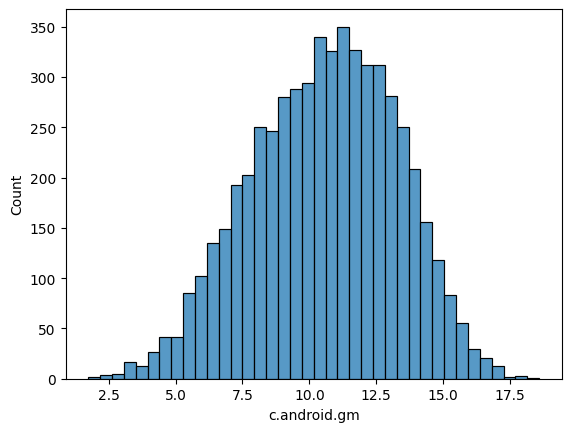

In [160]:
sns.histplot(androidgm0)

<Axes: xlabel='c.android.gm', ylabel='Count'>

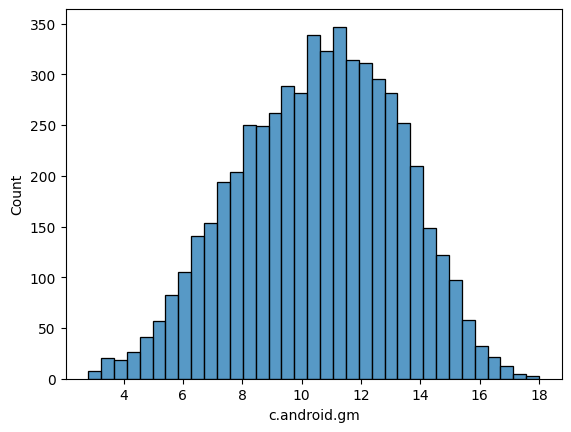

In [161]:
androidgm0 = androidgm0.drop(androidgm0_out.index)
sns.histplot(androidgm0)

In [162]:
androidgm1 = df_connections[df_connections['mwra'] == 1]['c.android.gm']
androidgm1.describe()

count    9313.000000
mean       10.557649
std         2.704660
min         2.355440
25%         8.532710
50%        10.269320
75%        12.446990
max        21.665490
Name: c.android.gm, dtype: float64

<Axes: xlabel='c.android.gm', ylabel='Count'>

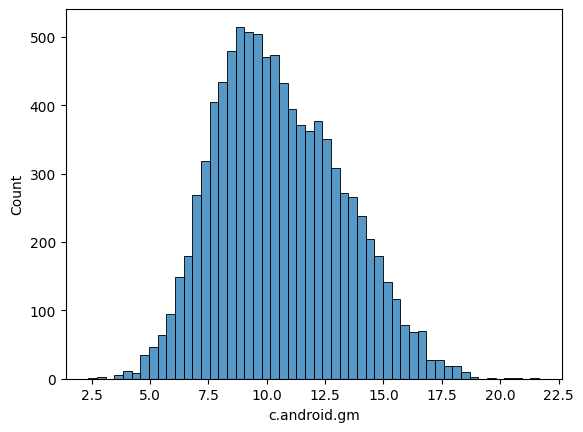

In [163]:
sns.histplot(androidgm1)

In [164]:
androidgm1_out = identify_outliers(androidgm1)
androidgm1_out

1057     18.63554
1117     18.32886
1151     18.41174
1458     21.66549
3113     18.65546
3519     18.79809
5099     18.39579
5962      2.35544
6723     19.59600
7213     18.38179
7243     18.59721
10563    18.68630
10822    18.82075
12556    18.38855
12883    18.86620
13005    20.88365
14440    20.32174
14663    18.54325
Name: c.android.gm, dtype: float64

<Axes: xlabel='c.android.gm', ylabel='Count'>

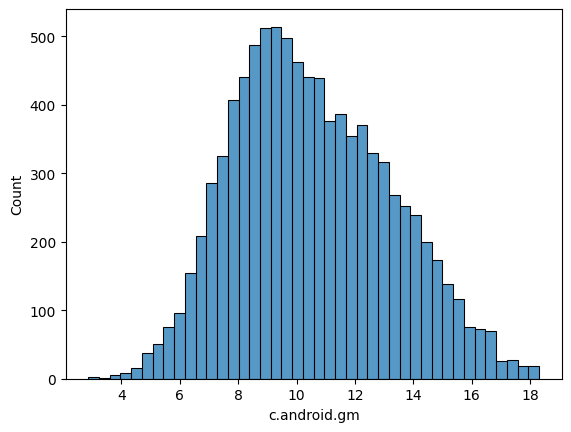

In [165]:
androidgm1 = androidgm1.drop(androidgm1_out.index)
sns.histplot(androidgm1)

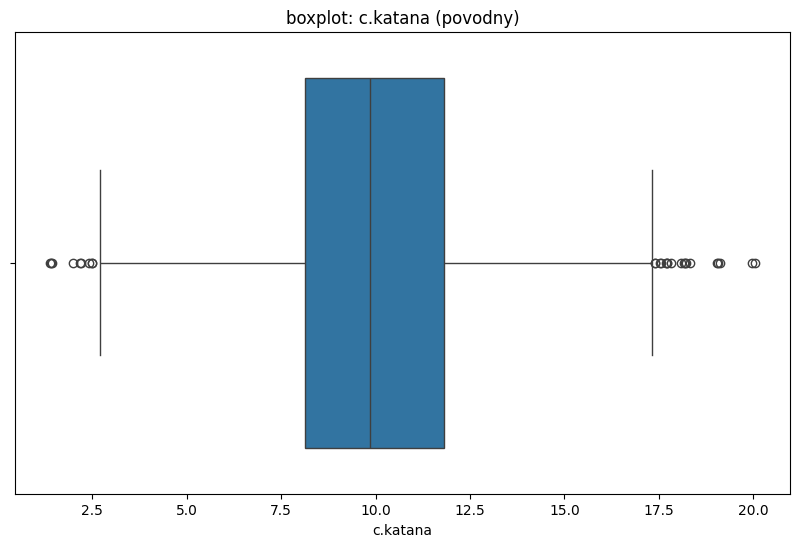

In [166]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_merged['c.katana'])
plt.title(f'boxplot: c.katana (povodny)')
plt.xlabel('c.katana')
plt.show()

In [167]:
z_scores = np.abs(stats.zscore(df_merged['c.katana']))
threshold = 3
df_no_outliers = df_merged['c.katana'][(z_scores < threshold)]

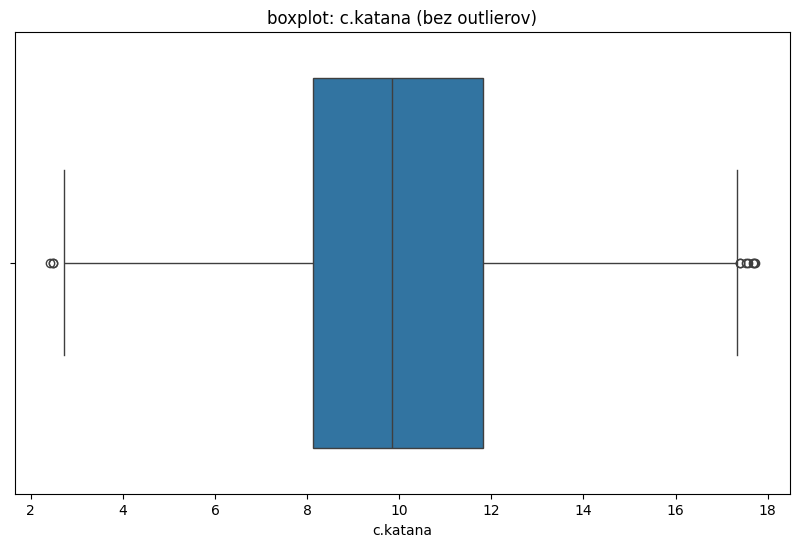

In [168]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_no_outliers)
plt.title(f'boxplot: c.katana (bez outlierov)')
plt.xlabel('c.katana')
plt.show()

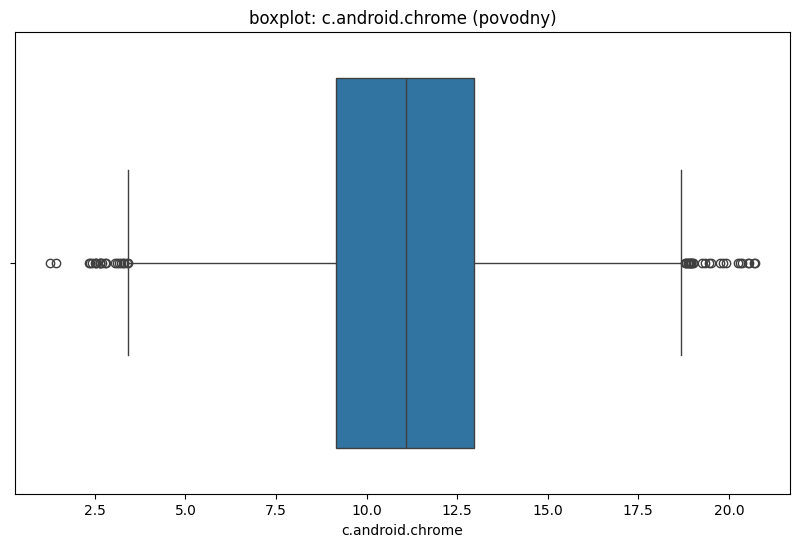

In [169]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_merged['c.android.chrome'])
plt.title(f'boxplot: c.android.chrome (povodny)')
plt.xlabel('c.android.chrome')
plt.show()

In [170]:
lower_bound = df_merged['c.android.chrome'].quantile(0.05)
upper_bound = df_merged['c.android.chrome'].quantile(0.95)

df_replaced_outliers = df_merged['c.android.chrome'].copy()
df_replaced_outliers[df_replaced_outliers < lower_bound] = lower_bound
df_replaced_outliers[df_replaced_outliers > upper_bound] = upper_bound

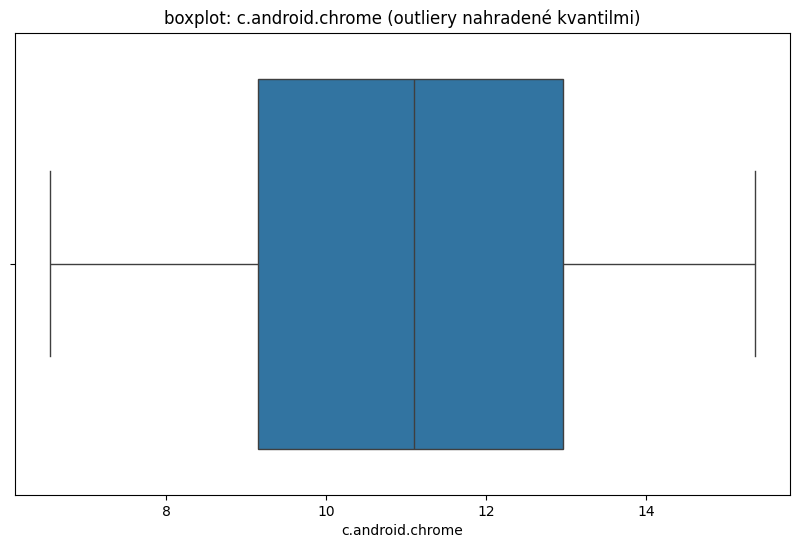

In [171]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_replaced_outliers)
plt.title(f'boxplot: c.android.chrome (outliery nahradené kvantilmi)')
plt.xlabel('c.android.chrome')
plt.show()

# 1.3 Formulácia a štatistické overenie hypotéz o dátach

### Hypoteza 1:
#### !Preformulovať!
**H₀**: Medzi skupinami zariadení bez malwaru (mwra = 0) a so škodlivým softvérom (mwra = 1) je signifikantný rozdiel v hodnote premenných pre aplikáciu 'c.android.gm'. (čo by mala byť aplikácia Gmail pre Android) -> *mwra je ovplyvnená aplikáciou Gmail*

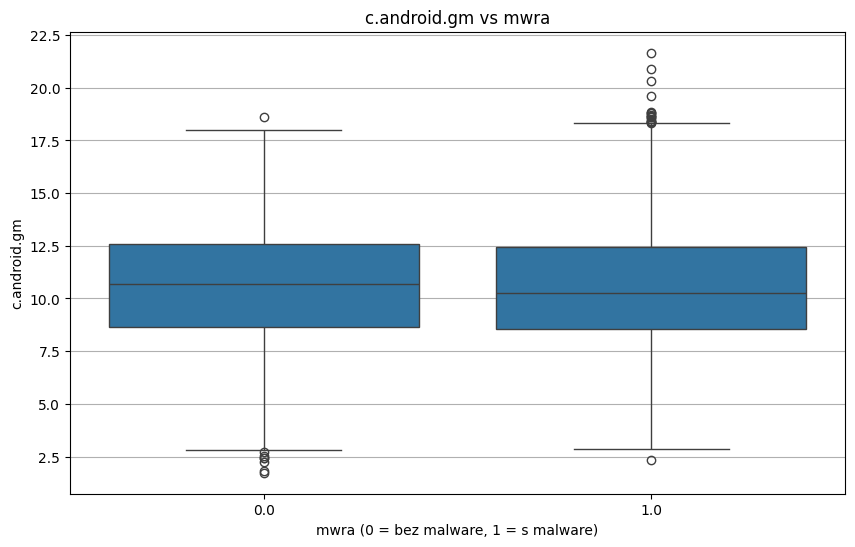

In [172]:
plt.figure(figsize=(10, 6))  
sns.boxplot(x='mwra', y='c.android.gm', data=df_connections)

plt.title('c.android.gm vs mwra')
plt.xlabel('mwra (0 = bez malware, 1 = s malware)')
plt.ylabel('c.android.gm')
plt.grid(axis='y')
plt.show()

In [173]:
group1 = df_connections[df_connections['mwra'] == 0]['c.android.gm']
group2 = df_connections[df_connections['mwra'] == 1]['c.android.gm']
t_stat, p_value = stats.ttest_ind(group1, group2)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -0.15944643234036365, P-value: 0.8733193238758349


In [174]:
from statsmodels.stats.power import TTestIndPower


effect_size = (np.mean(group1) - np.mean(group2)) / np.sqrt((np.var(group1) + np.var(group2)) / 2) 
alpha = 0.05 
n1 = len(group1)  
n2 = len(group2)  

analysis = TTestIndPower()
power = analysis.solve_power(effect_size=effect_size, nobs1=n1, alpha=alpha, ratio=n2/n1, alternative='two-sided')

print(f'Statistická sila testu pre 1. Hypotézu je {power}')


Statistická sila testu pre 1. Hypotézu je 0.05291352483741945


### !Preformulovať!
**Záver**: Keďže hodnota P **(~0.873)** je väčšia ako obvykle používaná hladina významnosti (napr. 0.05), nemáme dostatok dôkazov na zamietnutie nulovej hypotézy.  
**Znenie**: Vieme z tohto vyvodiť, že rozdiel nie je signifikantný medzi zariadeniami s (mwra = 1) v súvislosti s Gmail.

### Hypotéza 2:


**H₀** - android settings mwra?!

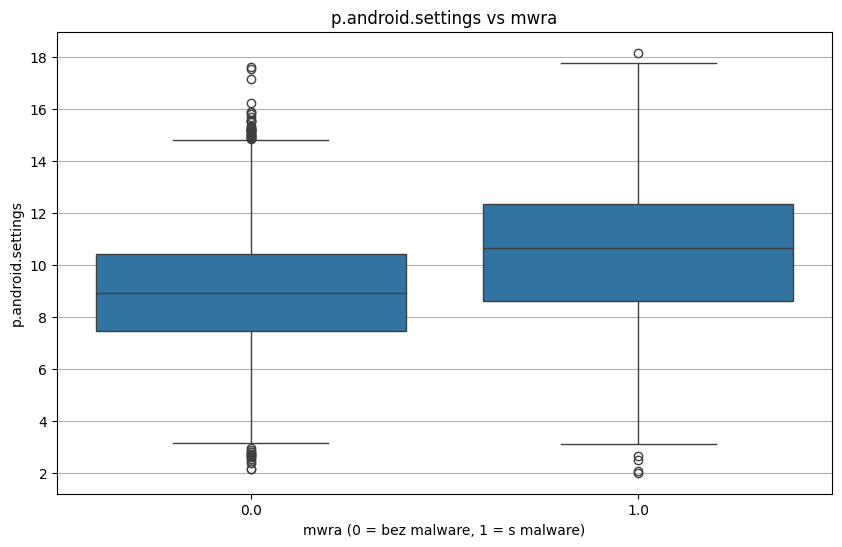

T-statistic: -37.03873914883136, P-value: 2.520797852490091e-287


In [175]:
plt.figure(figsize=(10, 6))  
sns.boxplot(x='mwra', y='p.android.settings', data=df_processes)

plt.title('p.android.settings vs mwra')
plt.xlabel('mwra (0 = bez malware, 1 = s malware)')
plt.ylabel('p.android.settings')
plt.grid(axis='y')

plt.show()

group1 = df_processes[df_processes['mwra'] == 0]['p.android.settings']
group2 = df_processes[df_processes['mwra'] == 1]['p.android.settings']
t_stat, p_value = stats.ttest_ind(group1, group2)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

Záver: Keďže p < 0.05 takže zamietam Nulovú hypotézu, (ano presne tak zamietam niečo čo som ešte nevytvoril deal with it!, btw I love data science) 

In [176]:
from statsmodels.stats.power import TTestIndPower


effect_size = (np.mean(group1) - np.mean(group2)) / np.sqrt((np.var(group1) + np.var(group2)) / 2)  # efekt veľkosti
alpha = 0.05  
n1 = len(group1)  
n2 = len(group2)  

analysis = TTestIndPower()
power = analysis.solve_power(effect_size=effect_size, nobs1=n1, alpha=alpha, ratio=n2/n1, alternative='two-sided')

print(f'Statistická sila testu pre 2. Hypotézu je {power}')


Statistická sila testu pre 2. Hypotézu je 1.0
